In [214]:
# работа с датафреймами и numpy-массивами
import pandas as pd
import numpy as np

# подготовка данных к обучению
from sklearn.model_selection import train_test_split

# обучение модели
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

# оценка точности модели
from sklearn import metrics

# удаление стоп-слов
import nltk

# лемматизация
import pymorphy2

# Отрисовка графиков
import matplotlib.pyplot as plt
import seaborn as sns

# Регулярные выражения
import re

## Загружаем набор данных

In [240]:
dfComments = pd.read_csv('labeled.csv')
dfComments.head()

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0


### Изучаем набор данных

<b>Смотрим на уникальность комментариев</b>

In [241]:
dfComments['comment'].describe()

count                                                 14412
unique                                                14412
top       Мое понимание: цена на сайте не является публи...
freq                                                      1
Name: comment, dtype: object

<b>Смотрим на распределение деструктивных комментариев</b>

In [242]:
dfComments['toxic'].describe()

count    14412.000000
mean         0.334860
std          0.471958
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: toxic, dtype: float64

In [243]:
print('Количество деструктивных комментариев:', len(dfComments[dfComments['toxic'] == 1]))
print('Количество недеструктивных комментариев:', len(dfComments[dfComments['toxic'] == 0]))

Количество деструктивных комментариев: 4826
Количество недеструктивных комментариев: 9586


## Обработка

<b>Представляем комментарии и метки в виде numpy-массивов</b>

In [244]:
text = np.array(dfComments.comment.values)
target = dfComments.toxic.astype(int).values

<b>Функция очистки и обработки текста</b>

In [248]:
morph = pymorphy2.MorphAnalyzer()
def lemmatize(text):
    res = list()
    for word in text:
        p = morph.parse(word)[0]
        res.append(p.normal_form)

    return res

In [249]:
# лемматизация
def cleanText(string):
    # Приводим буквы к нижнему регистру
    string = string.lower()
    # Убираем ссылки 
    string = re.sub(r"http\S+", "", string)
    # Убираем символы переноса строки
    string = string.replace('\\n', '')
    string = string.replace('\\', '')
    # Заменяем букву "ё" на "е"
    string = str.replace(string,'ё','е')
    # Ищем все буквенные конструкции и представляем их в виде токенов
    prog = re.compile('[А-Яа-яA-Za-z]+')
    words = prog.findall(string)
    # Удаляем стоп-слова
    stopwords = nltk.corpus.stopwords.words('russian')
    words = [w for w in words if w not in stopwords]
    ## Лемматизация и представление массива слов в виде строки
    resultString = ' '.join(lemmatize(words))
    return resultString

<b>Обрабатываем массив комментариев и смотрим результат на первых 10 строках</b>

In [250]:
text = list(map(cleanText, text))
i = 0
while i < 10:
    print(text[i])
    i += 1

верблюдов дебил бл
хохол это отдушина затюканый россиянин мол вон хохлов худой хохлов кисель придумать
собака собачий смерть
страница обновить дебил это оскорбление доказать факт дебил множественный число писать верить это твой воображать друг
убедить страничный пдф скрипаль отравить россия анализировать думать пытаться ватник
какой стан являться эталон современный система здравоохранение рф зимбабве тупой хохол
шапка ссылка инф текущий фильм марвести ссылка заменить фраза репортить брипидора игнорировать пост недостаточно понять модератор абсолютный неадекват нужно лишить полномочие этот борд пробивать абсолютный дно неадекватность
упад том строить технология разворовать трещина пош литр тупой китаз мочь нормальный сделать
ебать разносить шизик
обосраться сидеть обтекать


## Обучение модели

### Подготовка данных к обучению

<b>Для тестирования работы модели отводим 30% набора данных, 70% данных отводим для обучения</b>

In [251]:
X_train, X_test, y_train, y_test = train_test_split(text, target, test_size=.3, stratify=target, shuffle = True, random_state=0)
print('Количество комментариев для обучения:', len(X_train))
print("Количество комментариев для теста:", len(X_test))

Количество комментариев для обучения: 10088
Количество комментариев для теста: 4324


### Обучение модели

Обучаем модель

In [252]:
clf_pipeline = Pipeline(
            [("vectorizer", TfidfVectorizer()), # Prod feature: tokenizer=cleanText
            ("classifier", LinearSVC())]
        )

clf_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('classifier',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
   

Смотрим результаты классификации на матрице ошибок
<br>
Пояснения по поводу матрицы ошибок - https://www.bigdataschool.ru/blog/machine-learning-confusion-matrix.html

In [253]:
predict = clf_pipeline.predict(X_test)

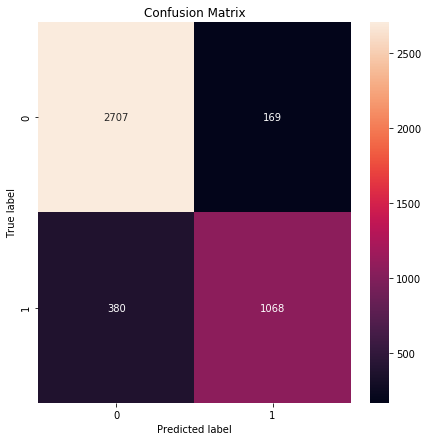

In [254]:
cm = metrics.confusion_matrix(y_test, predict)

def plotConfusionMatrix(cm):
    fig = plt.figure(figsize=(7,7))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return None

plotConfusionMatrix(cm)

Оценка точности модели

In [255]:
print(metrics.classification_report(y_test, predict))
f1_base = metrics.f1_score(y_test, predict)

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      2876
           1       0.86      0.74      0.80      1448

    accuracy                           0.87      4324
   macro avg       0.87      0.84      0.85      4324
weighted avg       0.87      0.87      0.87      4324



Оценка точности на основе F-меры

In [256]:
f1_base

0.7955307262569832

## Разметка сырого набора данных

Загружаем набор данных для разметки

In [257]:
df_raw = pd.read_csv("comments_raw.csv")
df_raw = df_raw.drop(["Unnamed: 0"], axis = 1)
df_raw.head()

,Post_ID,Text
0,115164,Такая же проблема. 3 дня не работает
1,115164,"Еще угар, что у них на сайте фотки не настоящи..."
2,115164,ну и прям все признаки конторы однодневки
3,115164,"это была шутка, брат"
4,115164,"не, так я про то что правда все признаки конто..."


Обработка текста

In [258]:
new_text = np.array(df_raw['Text'].values)
test = list(map(cleanText, new_text))

Оценка количества комментариев в обучающей и тестовой выборках

In [259]:
print('Количество комментариев для обучения:', len(text))
print("Количество комментариев для разметки:", len(test))

Количество комментариев для обучения: 14412
Количество комментариев для разметки: 61472


Обучение модели на обучающей выборке

In [260]:
clf_pipeline = Pipeline(
            [("vectorizer", TfidfVectorizer()), # Prod feature: tokenizer=cleanText
            ("classifier", LinearSVC())]
        )

clf_pipeline.fit(text, target)

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('classifier',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
   

Прогноз обученной моделе на тестовой выборке

In [261]:
predict = np.array(clf_pipeline.predict(test))

Замесь размеченного набора в файл

In [262]:
df_labeled = df_raw
df_labeled['predict'] = predict
df_labeled.to_csv('df_labeled.csv')
df_labeled.head()

,Post_ID,Text,predict
0,115164,Такая же проблема. 3 дня не работает,0
1,115164,"Еще угар, что у них на сайте фотки не настоящи...",0
2,115164,ну и прям все признаки конторы однодневки,0
3,115164,"это была шутка, брат",0
4,115164,"не, так я про то что правда все признаки конто...",0


Оценка количества деструктивных и недуструктивных комментариев

In [263]:
len(df_labeled[df_labeled['predict'] == 1])  # количество деструктивных комментариев

13122

In [264]:
len(df_labeled[df_labeled['predict'] == 0])  # количество недеструктивных комментариев

48350

Отбор деструктивных комментариев и запись в файл

In [265]:
df_toxic = df_labeled[df_labeled['predict'] == 1].drop(['predict'], axis = 1)
df_toxic.to_csv('df_toxic.csv')

In [266]:
df_toxic.head()

,Post_ID,Text
15,115136,понимаю твою боль
19,115124,чел ты...
21,115115,"Сапп: Юми, Сорака, Моргана \nМид: Люкса и Ари"
24,115115,"Пиши, скооперируемся!"
29,115115,"2 pos:\nИнвокер, морф, вивер\n3 pos:\nШейкер, ..."
